# AMG+ for 1D Helmholtz: The Repetitive Case
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [137]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [138]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Number of test vectors.  
ideal_tv = True  # False    # Use eigenvectors or not.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513016


## Level 0->1 Coarsening

In [139]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.316e+00                    4.468e-01    2.940
INFO     1     7.242e-01 (0.551) [0.551]    3.424e-01    2.116 (0.719)
INFO     2     4.219e-01 (0.584) [0.567]    2.936e-01    1.441 (0.681)
INFO     3     2.655e-01 (0.630) [0.588]    2.686e-01    0.993 (0.689)
INFO     4     1.829e-01 (0.689) [0.612]    2.537e-01    0.724 (0.730)
INFO     5     1.382e-01 (0.756) [0.638]    2.437e-01    0.569 (0.787)
INFO     6     1.125e-01 (0.814) [0.665]    2.361e-01    0.478 (0.840)
INFO     7     9.668e-02 (0.858) [0.690]    2.300e-01    0.420 (0.881)
INFO     8     8.588e-02 (0.887) [0.712]    2.249e-01    0.381 (0.907)
INFO     9     7.792e-02 (0.907) [0.731]    2.205e-01    0.353 (0.925)
INFO     10    7.170e-02 (0.920) [0.748]    2.166e-01    0.330 (0.936)
INFO     11    6.671e-02 (0.930) [0.763]    2.131e-01    0.312 (0.946)
INFO     12    6.263e-02 (0.939) [0.776]    2.099e-01    0.298 (0.953)
INFO 

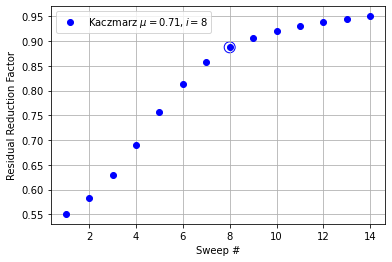

In [140]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [141]:
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, num_sweeps))
    x = hm.setup.auto_setup.get_test_matrix(a, num_sweeps, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 3 ideal TVs


### Coarsening: Fixed (4/2)

In [142]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

Coarsening: a 4 nc 2 #windows 15 s [0.716 0.387 0.014 0.001]


,0,1,2,3,4,5,6,7,8,9
0,-0.43,-0.57,-0.56,-0.42,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.24,0.25,0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.43,-0.57,-0.56,-0.42,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.24,0.25,0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.43,-0.57


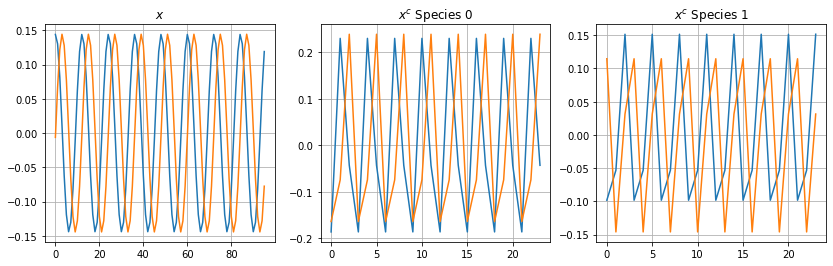

In [143]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [131]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.457 0.296 0.179 0.134 0.145 0.107 0.084 0.074]


### Interpolation $P = R^T$

In [132]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[-0.417  0.67 ]
 [-0.56   0.251]
 [-0.567 -0.233]
 [-0.437 -0.658]]


,1,2,3,4,5,6,7,8
Mock,0.46,0.30,0.18,0.13,0.14,0.11,0.08,0.07
Two-level,0.52,0.37,0.43,0.44,0.41,0.41,0.40,0.39


INFO     L2 projection norm 1.00 A*A' projection norm 2.84


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [133]:
calibers = (2, 3, 4)
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)
        interpolation_method = "ls"
        neighborhood = "extended"

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber)

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))

        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction), 
                nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append(two_level_conv)
        p_caliber.append(p)

    conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                        index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                                  for caliber in calibers)).transpose()
    display(conv)

P^T*A*P
INFO     caliber 2 error l2 [0.02] a [5.69e+12]
INFO     caliber 3 error l2 [0.01] a [4.38e+12]
INFO     caliber 4 error l2 [0.00] a [6.62e-01]


,1,2,3,4,5,6,7,8
Mock,0.46,0.30,0.18,0.13,0.14,0.11,0.08,0.07
Caliber 2,0.51,0.36,0.41,0.44,0.38,0.37,0.38,0.38
Caliber 3,0.60,0.35,0.30,0.36,0.30,0.27,0.28,0.28
Caliber 4,0.59,0.33,0.21,0.14,0.15,0.14,0.10,0.07


R*A*P
INFO     caliber 2 error l2 [0.02] a [5.69e+12]
INFO     caliber 3 error l2 [0.01] a [4.38e+12]
INFO     caliber 4 error l2 [0.00] a [6.62e-01]


,1,2,3,4,5,6,7,8
Mock,0.46,0.30,0.18,0.13,0.14,0.11,0.08,0.07
Caliber 2,0.51,0.35,0.42,0.44,0.38,0.37,0.38,0.38
Caliber 3,0.58,0.34,0.33,0.39,0.33,0.32,0.32,0.32
Caliber 4,0.68,0.37,0.28,0.22,0.17,0.14,0.11,0.08


In [134]:
for caliber, p in zip(calibers, p_caliber):
#    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
#    display_html(styler._repr_html_(), raw=True)
    ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
    ac = ml[1].a
    print("caliber {} nnz(P) {} fill-in {:.2f}".format(caliber, p.nnz, (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])))
    print("Max abs |Ac - Ac^T| {:.3e}".format(np.max(np.abs(ac - ac.transpose()))))
    display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                            pd.DataFrame(ac.todense()[:10,:10]), 
                        captions=("P", "A^1"))

caliber 2 nnz(P) 192 fill-in 1.20
Max abs |Ac - Ac^T| 1.743e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.41 
 0.67 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.56 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.57 
 -0.23 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.44 
 -0.66 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 -0.41 
 0.67 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.56 
 0.25 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.17 
 -0.02 
 0.20 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.02 
 -1.47 
 0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.20 
 0.33 
 -0.17 
 -0.02 
 0.20 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.35 
 -0.56 
 -0.02 
 -1.47 
 0.33 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.20 
 0.33 
 -0.17 
 -0.02 
 0.20 
 -0.35 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.35 
 -0.56 
 -0.02 
 -1.47 
 0.33 
 -0.56 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.20 
 0.33 
 -0.17 
 -0.02 
 0.20 
 -0.35 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.35 
 -0.56 
 -0.02 
 -1.47 
 0.33 
 -0.56 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.20 
 0.33 
 -0.17 
 -0.02 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.35 
 -0.56 
 -0.02 
 -1.47

caliber 3 nnz(P) 288 fill-in 1.20
Max abs |Ac - Ac^T| 1.685e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.44 
 0.60 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.54 
 0.31 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.55 
 -0.29 
 0.04 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.45 
 -0.59 
 -0.05 
 0.00 
 0.00 
 0.00 
 
 
 4 
 -0.05 
 0.00 
 -0.44 
 0.60 
 0.00 
 0.00 
 
 
 5 
 0.04 
 0.00 
 -0.54 
 0.31 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.13 
 -0.02 
 0.20 
 -0.31 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.02 
 -1.30 
 0.29 
 -0.50 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.20 
 0.29 
 -0.13 
 -0.02 
 0.20 
 -0.31 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.31 
 -0.50 
 -0.02 
 -1.30 
 0.29 
 -0.50 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.20 
 0.29 
 -0.13 
 -0.02 
 0.20 
 -0.31 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.31 
 -0.50 
 -0.02 
 -1.30 
 0.29 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.20 
 0.29 
 -0.13 
 -0.02 
 0.20 
 -0.31 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.31 
 -0.50 
 -0.02 
 -1.30 
 0.29 
 -0.50 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.20 
 0.29 
 -0.13 
 -0.02 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.31 
 -0.50 
 -0.02 
 -1.30

caliber 4 nnz(P) 384 fill-in 1.20
Max abs |Ac - Ac^T| 1.468e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.37 
 0.44 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.59 
 0.42 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.60 
 -0.40 
 0.08 
 -0.11 
 0.00 
 0.00 
 
 
 3 
 -0.38 
 -0.43 
 -0.10 
 0.17 
 0.00 
 0.00 
 
 
 4 
 -0.11 
 -0.17 
 -0.37 
 0.44 
 0.00 
 0.00 
 
 
 5 
 0.08 
 0.11 
 -0.59 
 0.42 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.03 
 -0.01 
 0.15 
 -0.17 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.01 
 -0.61 
 0.16 
 -0.15 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.15 
 0.16 
 -0.03 
 -0.01 
 0.15 
 -0.17 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.17 
 -0.15 
 -0.01 
 -0.61 
 0.16 
 -0.15 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.15 
 0.16 
 -0.03 
 -0.01 
 0.15 
 -0.17 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.17 
 -0.15 
 -0.01 
 -0.61 
 0.16 
 -0.15 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.15 
 0.16 
 -0.03 
 -0.01 
 0.15 
 -0.17 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.17 
 -0.15 
 -0.01 
 -0.61 
 0.16 
 -0.15 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.15 
 0.16 
 -0.03 
 -0.01 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.17 
 -0.15 
 -0.01 
 -0.61

$R A P$ is nearly symmetric, and is sparser than $P^T A P$, while giving almost the same 2-level convergence factors for $\nu \geq 2$.

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.855e+01 RER 3.32360
INFO         1 |r| 2.146e+00 (0.11570) RER 0.34520 (0.10386) 6.216
INFO         2 |r| 2.742e-01 (0.12780) RER 0.04482 (0.12984) 6.119
INFO         3 |r| 3.352e-02 (0.12223) RER 0.00513 (0.11452) 6.531
INFO         4 |r| 3.545e-03 (0.10574) RER 0.00056 (0.11004) 6.275
INFO         5 |r| 4.987e-04 (0.14071) RER 0.00009 (0.15346) 5.754
INFO         6 |r| 6.580e-05 (0.13193) RER 0.00001 (0.10975) 6.916
INFO         7 |r| 8.715e-06 (0.13246) RER 0.00000 (0.13030) 7.031
INFO         8 |r| 1.186e-06 (0.13613) RER 0.00000 (0.13020) 7.350
INFO         9 |r| 1.657e-07 (0.13966) RER 0.00000 (0.16586) 6.189
INFO        10 |r| 2.336e-08 (0.14097) RER 0.00000 (0.13340) 6.540
INFO        11 |r| 3.299e-09 (0.14123) RER 0.00000 (0.13554) 6.815
INFO        12 |r| 4.685e-10 (0.14202) RER 0.00000 (0.13532) 7.152
INFO        13 |r| 6.716e-11 (0.14336) RER 0.00000 (0.15274) 6.713


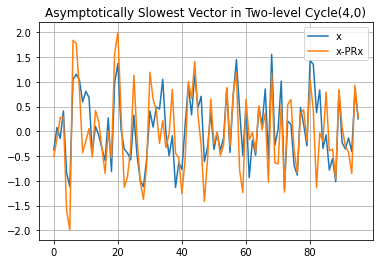

In [157]:
nu = 4
p = p_caliber[-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [158]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.     0.     0.064  0.064 -0.072 -0.072  0.12   0.12  -0.153 -0.153  0.167  0.167]


#### $R A P$

INFO         0 |r| 1.766e+01 RER 3.32406
INFO         1 |r| 3.428e+00 (0.19409) RER 0.00000 (0.00000) 394645631096271.250
INFO         2 |r| 3.750e+00 (1.09408) RER 0.00000 (0.56857) 759399329840598.750
INFO         3 |r| 5.020e+00 (1.33855) RER 0.00000 (0.88796) 1144754219720008.750
INFO         4 |r| 7.472e+00 (1.48851) RER 0.00000 (0.94140) 1810045219001764.500
INFO         5 |r| 1.192e+01 (1.59473) RER 0.00000 (1.12505) 2565702401689969.000
INFO         6 |r| 1.984e+01 (1.66478) RER 0.00000 (1.13855) 3751556915787043.500
INFO         7 |r| 3.366e+01 (1.69699) RER 0.00000 (1.28889) 4939418316571673.000
INFO         8 |r| 5.758e+01 (1.71064) RER 0.00000 (1.10355) 7656730611046928.000
INFO         9 |r| 1.002e+02 (1.74028) RER 0.00000 (1.11109) 11992612155345592.000
INFO        10 |r| 1.736e+02 (1.73185) RER 0.00000 (1.16484) 17830228070452914.000
INFO        11 |r| 3.023e+02 (1.74188) RER 0.00000 (1.07085) 29003270021469116.000
INFO        12 |r| 5.278e+02 (1.74600) RER 0.00000 (1.17

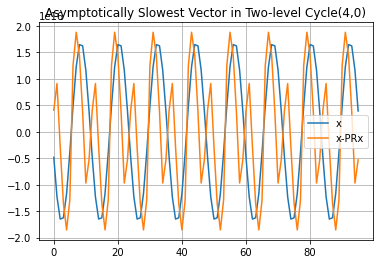

In [144]:
nu = 4
p = p_caliber[-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=True)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [170]:
y.T.dot(multilevel[0].a.dot(y)) / (y.T.dot(y))

-1.7732206484302744

In [159]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.     0.     0.064  0.064 -0.072 -0.072  0.12   0.12  -0.153 -0.153  0.167  0.167]


This is a combination